2024-05-22 22:26:12.636079: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 22:26:12.661890: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 22:26:13.684582: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-22 22:26:13.690578:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn (SimpleRNN)                 │ (None, 30, 256)        │        66,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ (None, 30, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputprobs (Dense)             │ (None, 30, 3)          │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,099 (266.01 KB)

 Trainable params: 67,587 (264.01 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100


I0000 00:00:1716438374.438111  918431 service.cc:145] XLA service 0x7f18200d0760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716438374.438135  918431 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2024-05-22 22:26:14.457837: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-22 22:26:14.542171: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/7 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.0210 - custom_cat: 0.2909 - loss: 2.1972

I0000 00:00:1716438375.036054  918431 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.0213 - custom_cat: 0.2998 - loss: 2.1972 - val_accuracy: 0.0257 - val_custom_cat: 0.2522 - val_loss: 2.1972
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0212 - custom_cat: 0.3016 - loss: 2.1972 - val_accuracy: 0.0254 - val_custom_cat: 0.2535 - val_loss: 2.1972
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0212 - custom_cat: 0.2992 - loss: 2.1972 - val_accuracy: 0.0252 - val_custom_cat: 0.2555 - val_loss: 2.1972
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0216 - custom_cat: 0.3037 - loss: 2.1972 - val_accuracy: 0.0249 - val_custom_cat: 0.2582 - val_loss: 2.1972
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0212 - custom_cat: 0.2988 - loss: 2.1972 - val_accuracy: 0.0247 - val_custom_cat: 0.2595 - val_loss: 2.1972
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0211 - custom_cat: 0.2929 - loss: 2.1972 - val_accuracy: 0.0245 - val_custom_cat: 0.2609 - v

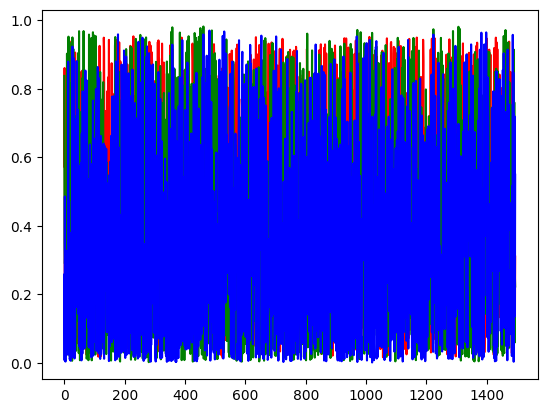

In [1]:
import numpy as np
import sklearn.model_selection as sk
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as kb
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
import random


#gonna work in radians

numberAngles = 80 #how many orientations each side can take

angleMax = np.pi/2
angleMin = -np.pi/2



angleList = np.linspace(angleMin, angleMax, numberAngles)

def difficulty(angle1, angle2):
    sameSign = True
    difference = abs( abs(angle1) - abs(angle2) )

    if abs(angle1 + angle2) < abs(angle1)+abs(angle2): #if they are opposite sign
        sameSign = False
        
    beta = 0.06 #slope parameter for steepness of difficulty curve (a function of angle separation)
    alpha = .028 #Value of difficulty at angle difference of max

    offset = np.arctanh( 2*alpha - 1 )/beta #shift the graph so at x = 0 f(x) is alpha

    f = .4 #Parameter for the slope of the mapping of difference to input to the difficulty function
    
    if not sameSign: #the angles are not the same side so add a bias to the difficulty
        y = 0.6  #parameter affecting how much f is changed when the angles are on same side or not
        f = f - y*f

    x = 1/(f*difference) #scale it so small differences are large value and big differences are small
    dif = 1/2 * ( np.tanh( beta * (x + offset) ) + 1 )
    return dif


#Generate training data

#list that holds the pairs [left angle, right angle]
anglePairs = []

#generate all pairs of angles
for i in angleList:
    for j in angleList:      #round to deal with floating point error
        decimals = 1
        if (round(i,decimals) != round(j,decimals)) & (-round(i,decimals) != round(j,decimals)): #we dont want any pairs that have equal verticallity (same abs(angle))
            #add noise to the angles
            noiseScale = 10 #scales how noise the angles are
            i += np.random.randn()/noiseScale
            j += np.random.randn()/noiseScale
            anglePairs.append([i,j])


#make the list a np array 
angPair = np.zeros((len(anglePairs), 2))
counter = 0
for i in anglePairs:
    angPair[counter][0] = i[0]
    angPair[counter][1] = i[1]
    counter +=1
anglePairs = angPair

np.random.shuffle(anglePairs)


def correctChoice(angle1, angle2):
    '''input 2 angles return the smaller angle corresponding to more vertical orientation
       Angle 1 is left angle 2 is right. Returns -1 for Left 1 for right
       if they are equal error is thrown because currently only training on non equal angles
    '''
    if angle1 < angle2:
        return -1        #The left bar is oriented more vertically
    elif angle2 < angle1:
        return 1        #The right bar is oriented more vertically
    else:
        return "Error. Not expecting equal angles" #throw error if angles are equal


def trainedChoice(angle1, angle2):
    '''Input two angles returns the choice the mouse makes'''
    diff = difficulty(angle1, angle2)

    pCorrect = -0.5*diff + 1 #probability they are correct
    
    cor = correctChoice(angle1,angle2)

    n = np.random.random()

    if n <= pCorrect: #if they are certain
        return cor
    else:
          #if not certain then it is a guess
        g = np.random.rand()
        if g < .5:
            return cor
        else:
            return -cor
    
numberTrials = len(anglePairs)

#create the lists of trained and correct choices
corCh = np.zeros(numberTrials) #List of correct choices
trainedCh = np.zeros(numberTrials) #List of trained choices

counter = 0
for i in anglePairs:
    angle1 = i[0]
    angle2 = i[1]
    corCh[counter] = correctChoice(angle1, angle2)
    trainedCh[counter] = trainedChoice(angle1, angle2)
    counter += 1

 

#create the time series
stimDur = 1.5 #length of the stimulus (seconds)
preStimDur = 1 #length of the pre stimulus (seconds)

frameRate = 12 #(hz)

totalFrames = int(frameRate*(stimDur + preStimDur)) #total number of frames



trialsData = np.zeros((numberTrials, totalFrames, 2)).astype(np.float32) #stores the trials time series'

responseData = np.full((numberTrials, totalFrames), np.nan) #stores the response time series

dt =  1/frameRate

#calculate the frame immediately before the stimulus 
preStimulusFrame = preStimDur * frameRate - 1


for iteration in range(numberTrials): #for each experiment create a time series
    t = 0
    for frame in range(totalFrames): 
        if frame <= preStimulusFrame: #startwith noise in range [-90 deg, 90 deg] when no stimulus present
            #generate 2 random angles in [-90 deg, 90 deg]
            ang1 = np.random.rand()
            ang1 = ang1 * np.pi/2
            swap = np.random.rand()
            if swap > .5:
                ang1 = -ang1
            ang2 = np.random.rand()
            ang2 = ang2 * np.pi/2
            swap = np.random.rand()
            if swap > .5:
                ang2 = -ang2
            trialsData[iteration][frame][0] = ang1
            trialsData[iteration][frame][1] = ang2
            if frame == preStimulusFrame: #frame before stimulus
                responseData[iteration][frame] = 0
    
        else:
            #use the angles corresponding to stimulus
            angles = anglePairs[iteration]
       
            trialsData[iteration][frame][0] = angles[0]
            trialsData[iteration][frame][1] = angles[1]
            if frame == totalFrames - 1 :#last frame
                responseData[iteration][frame] = trainedCh[iteration]
            
        t += dt



xTrain, xTest, yTrain, yTest = sk.train_test_split(trialsData, 
                                        responseData, 
                                        test_size=0.25, 
                                        random_state=None)


units = 256 # Number of neurons in the dense layer
output_size = 3 # Number of output states



# Only use 2 frames: 1. Before the stimulus (so both left and right prob are 0). 2. The last frame

def custom_loss(y_actual,y_pred): 
    


    l1 = kb.sparse_categorical_crossentropy(y_actual[:, preStimulusFrame]+1, y_pred[:, preStimulusFrame]+1)
    l2 = kb.sparse_categorical_crossentropy(y_actual[:, -1]+1, y_pred[:, -1]+1)
    custom_loss = l1 + l2
    
   
    return custom_loss

# Only use the last frame
def custom_cat(y_actual,y_pred): 
    l2 = tf.keras.metrics.sparse_categorical_accuracy(y_actual[:, -1], y_pred[:, -1])
    custom_cat = l2
  
    return custom_cat



model = keras.models.Sequential()
model.add(Input(shape = (xTrain.shape[1], xTrain.shape[2])))
model.add(layers.SimpleRNN(units, activation = 'relu', return_sequences = True, name = 'rnn'))
model.add(layers.BatchNormalization(name = 'batch_norm'))
model.add(layers.Dense(output_size, activation = 'softmax', name = 'outputprobs'))

model.summary()


batch_size = 660 # Trials per batch
MAX_EPOCHS = 100 # Total epochs

metrr = ['accuracy', custom_cat]

model.compile(
    loss=custom_loss,
    optimizer="adam",
    metrics=metrr,
)



history = model.fit(xTrain, yTrain, epochs = MAX_EPOCHS, batch_size = batch_size, verbose = True,
   validation_data = (xTest, yTest))
yTestPredict = model.predict(xTest)



one = []
two = []
three = []


for a in yTestPredict:
    one.append(a[0][0])
    two.append(a[1][0])
    three.append(a[2][0])



plt.plot(one, c='r')
plt.plot(two, c='g')
plt.plot(three,c='b')

plt.show()










    






